In [1]:
# Import stuff
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import matplotlib as plt

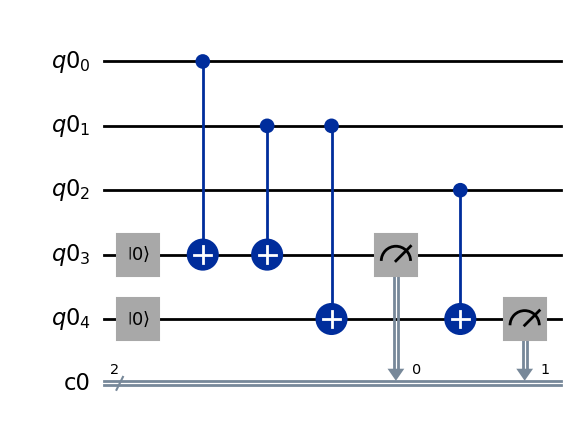

In [2]:
# Quantum bit-flip error correction code
q_regs = QuantumRegister(5)
m_regs = ClassicalRegister(2)

qec_bit = QuantumCircuit(q_regs, m_regs)

# Set up qubits except for 0 to |0>
qec_bit.initialize([1, 0], q_regs[3])
qec_bit.initialize([1, 0], q_regs[4])

# Compute parity
qec_bit.cx(q_regs[0], q_regs[3])
qec_bit.cx(q_regs[1], q_regs[3])
qec_bit.cx(q_regs[1], q_regs[4])
qec_bit.cx(q_regs[2], q_regs[4])

# Measure ancilla qubits
qec_bit.measure(q_regs[3], m_regs[0])
qec_bit.measure(q_regs[4], m_regs[1])

# NOTE: Needs to be done separately
# with qec_bit.if_test((m_regs, 0b01)):
#     qec_bit.x(q_regs[0])
# with qec_bit.if_test((m_regs, 0b10)):
#     qec_bit.x(q_regs[2])
# with qec_bit.if_test((m_regs, 0b11)):
#     qec_bit.x(q_regs[1])

# Transpile the circuit 
qec_bit = qec_bit.decompose()
qec_bit = transpile(qec_bit, basis_gates=['rz', 'sx', 'x', 'cx'] , optimization_level=3)

# Draw the circuit
qec_bit.draw('mpl')

In [3]:
# Function to error-correct a circuit on a given map of qubits and cbits
def error_correct(circuit: QuantumCircuit, qlist: list, clist: list):
    """
    Error-correct a circuit on a given map of qubits and cbits.
    """
    # Modify the circuit
    with circuit.if_test((clist[0], 1)) as else__:
        with circuit.if_test((clist[1], 0)) as else_:
            circuit.x(qlist[0])
        with else_:
            circuit.x(qlist[2])
    with else__:
        with circuit.if_test((clist[1], 1)) as else_:
            circuit.x(qlist[1])

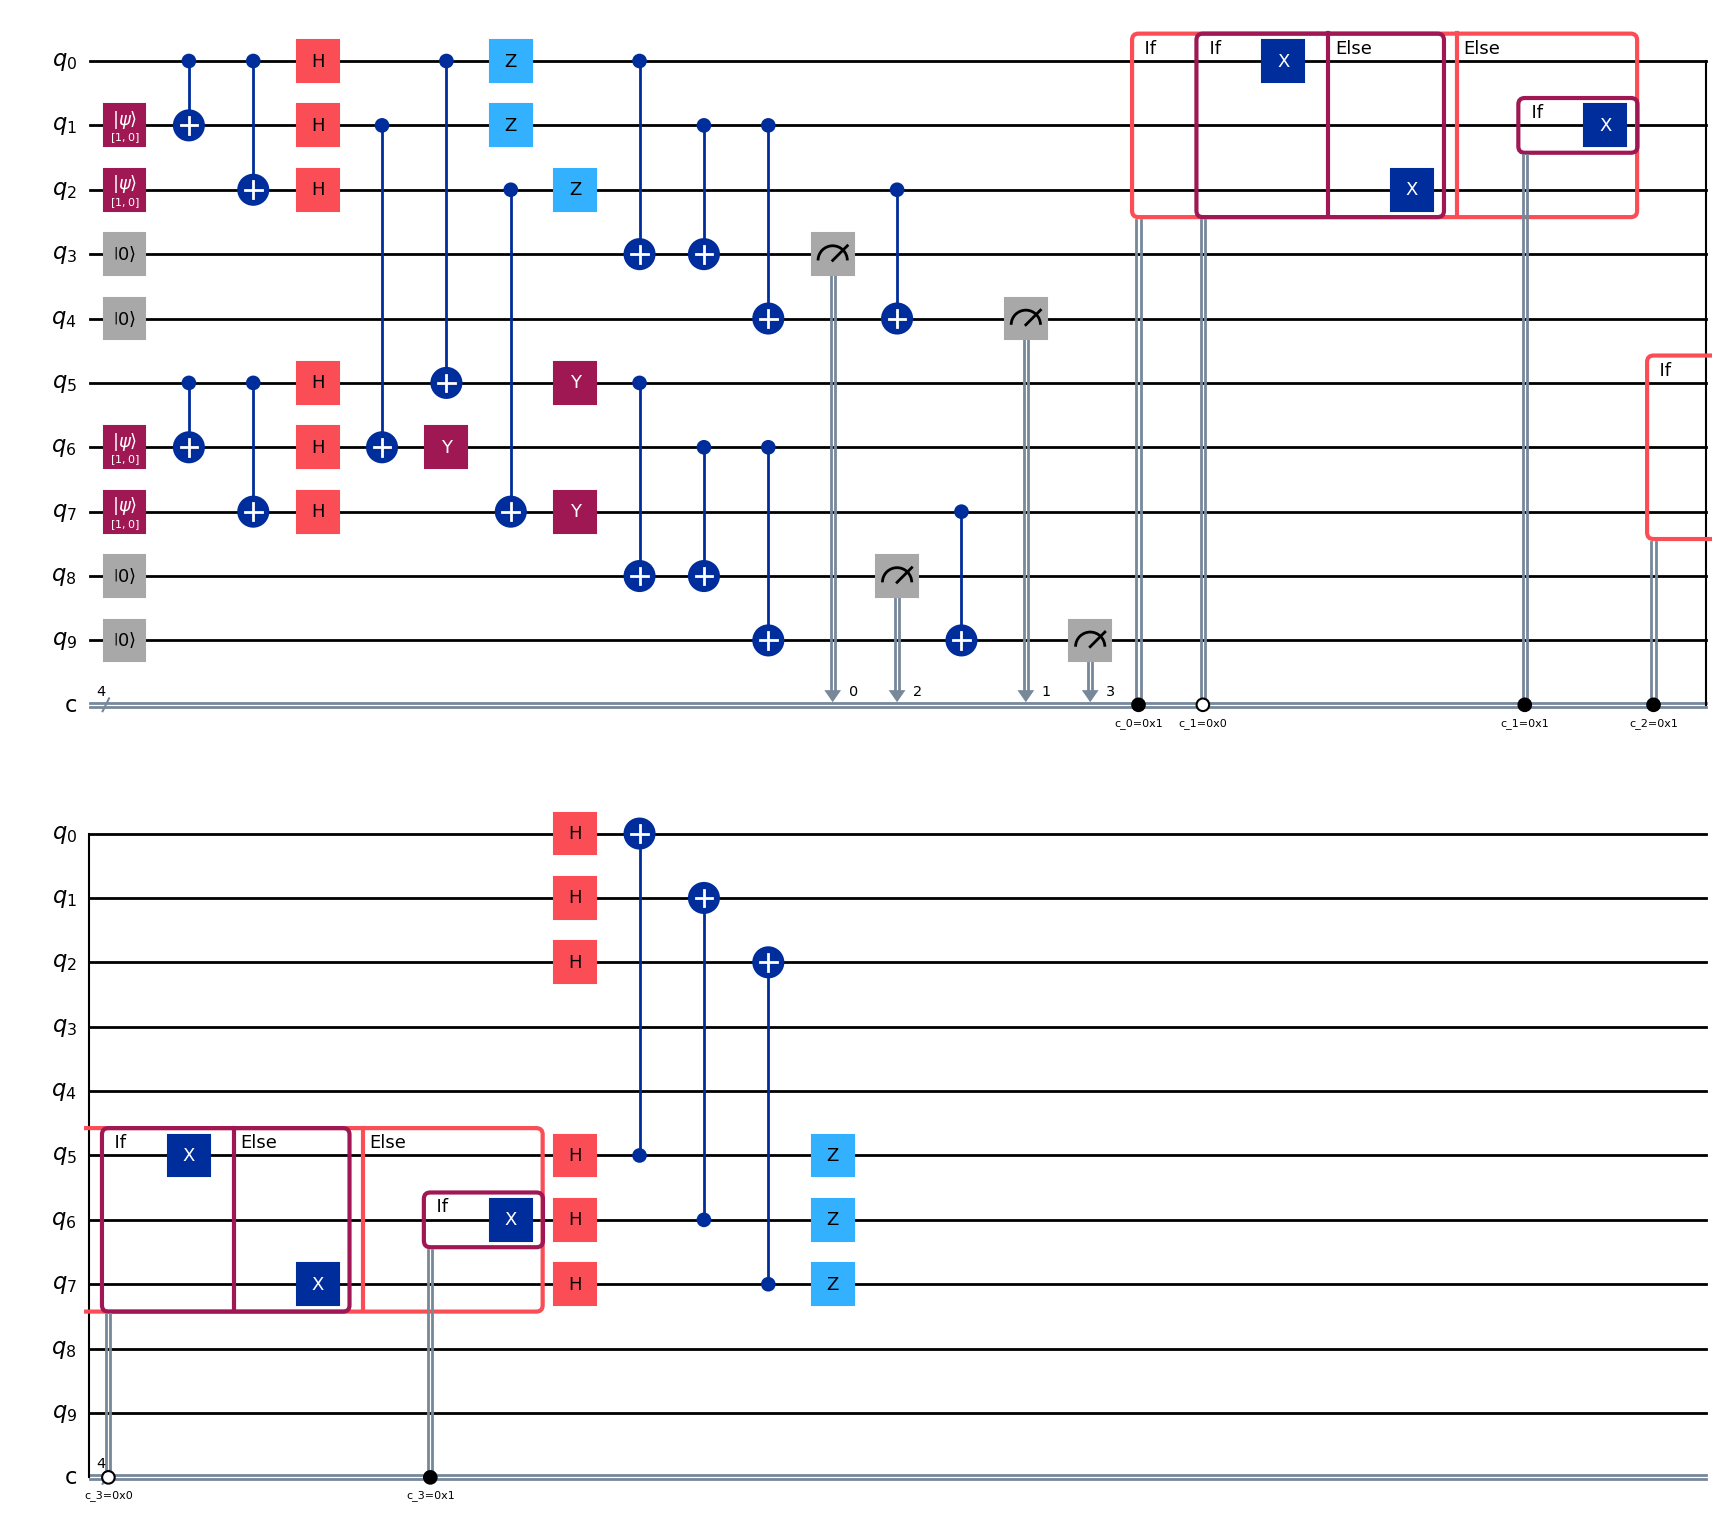

In [4]:
# Append to a bigger circuit
num_qubits = 2
qc = QuantumCircuit(5*num_qubits, 2*num_qubits)

# Duplicate
for i in range(num_qubits):
    qc.initialize([1, 0], qc.qubits[5*i+1])
    qc.initialize([1, 0], qc.qubits[5*i+2])
    qc.cx(qc.qubits[5*i], qc.qubits[5*i+1])
    qc.cx(qc.qubits[5*i], qc.qubits[5*i+2])

# Do operations on physical qubits (before)
a = 0
b = 5
for i in range(3):
    qc.h(qc.qubits[a+i])
    qc.h(qc.qubits[b+i])
    qc.cx(qc.qubits[a+i], qc.qubits[b+i])
    qc.z(qc.qubits[a+i])
    qc.y(qc.qubits[b+i])


# Error correct fir
qc.compose(qec_bit, [0, 1, 2, 3, 4], [0, 1], inplace=True)
error_correct(qc, [0, 1, 2, 3], [0, 1])

qc.compose(qec_bit, [5, 6, 7, 8, 9], [2, 3], inplace=True)
error_correct(qc, [5, 6, 7, 8], [2, 3])

# Do operations on physical qubits (after)
for i in range(3):
    qc.h(qc.qubits[a+i])
    qc.h(qc.qubits[b+i])
    qc.cx(qc.qubits[b+i], qc.qubits[a+i])
    qc.z(qc.qubits[b+i])

# Draw the circuit
qc.draw('mpl')

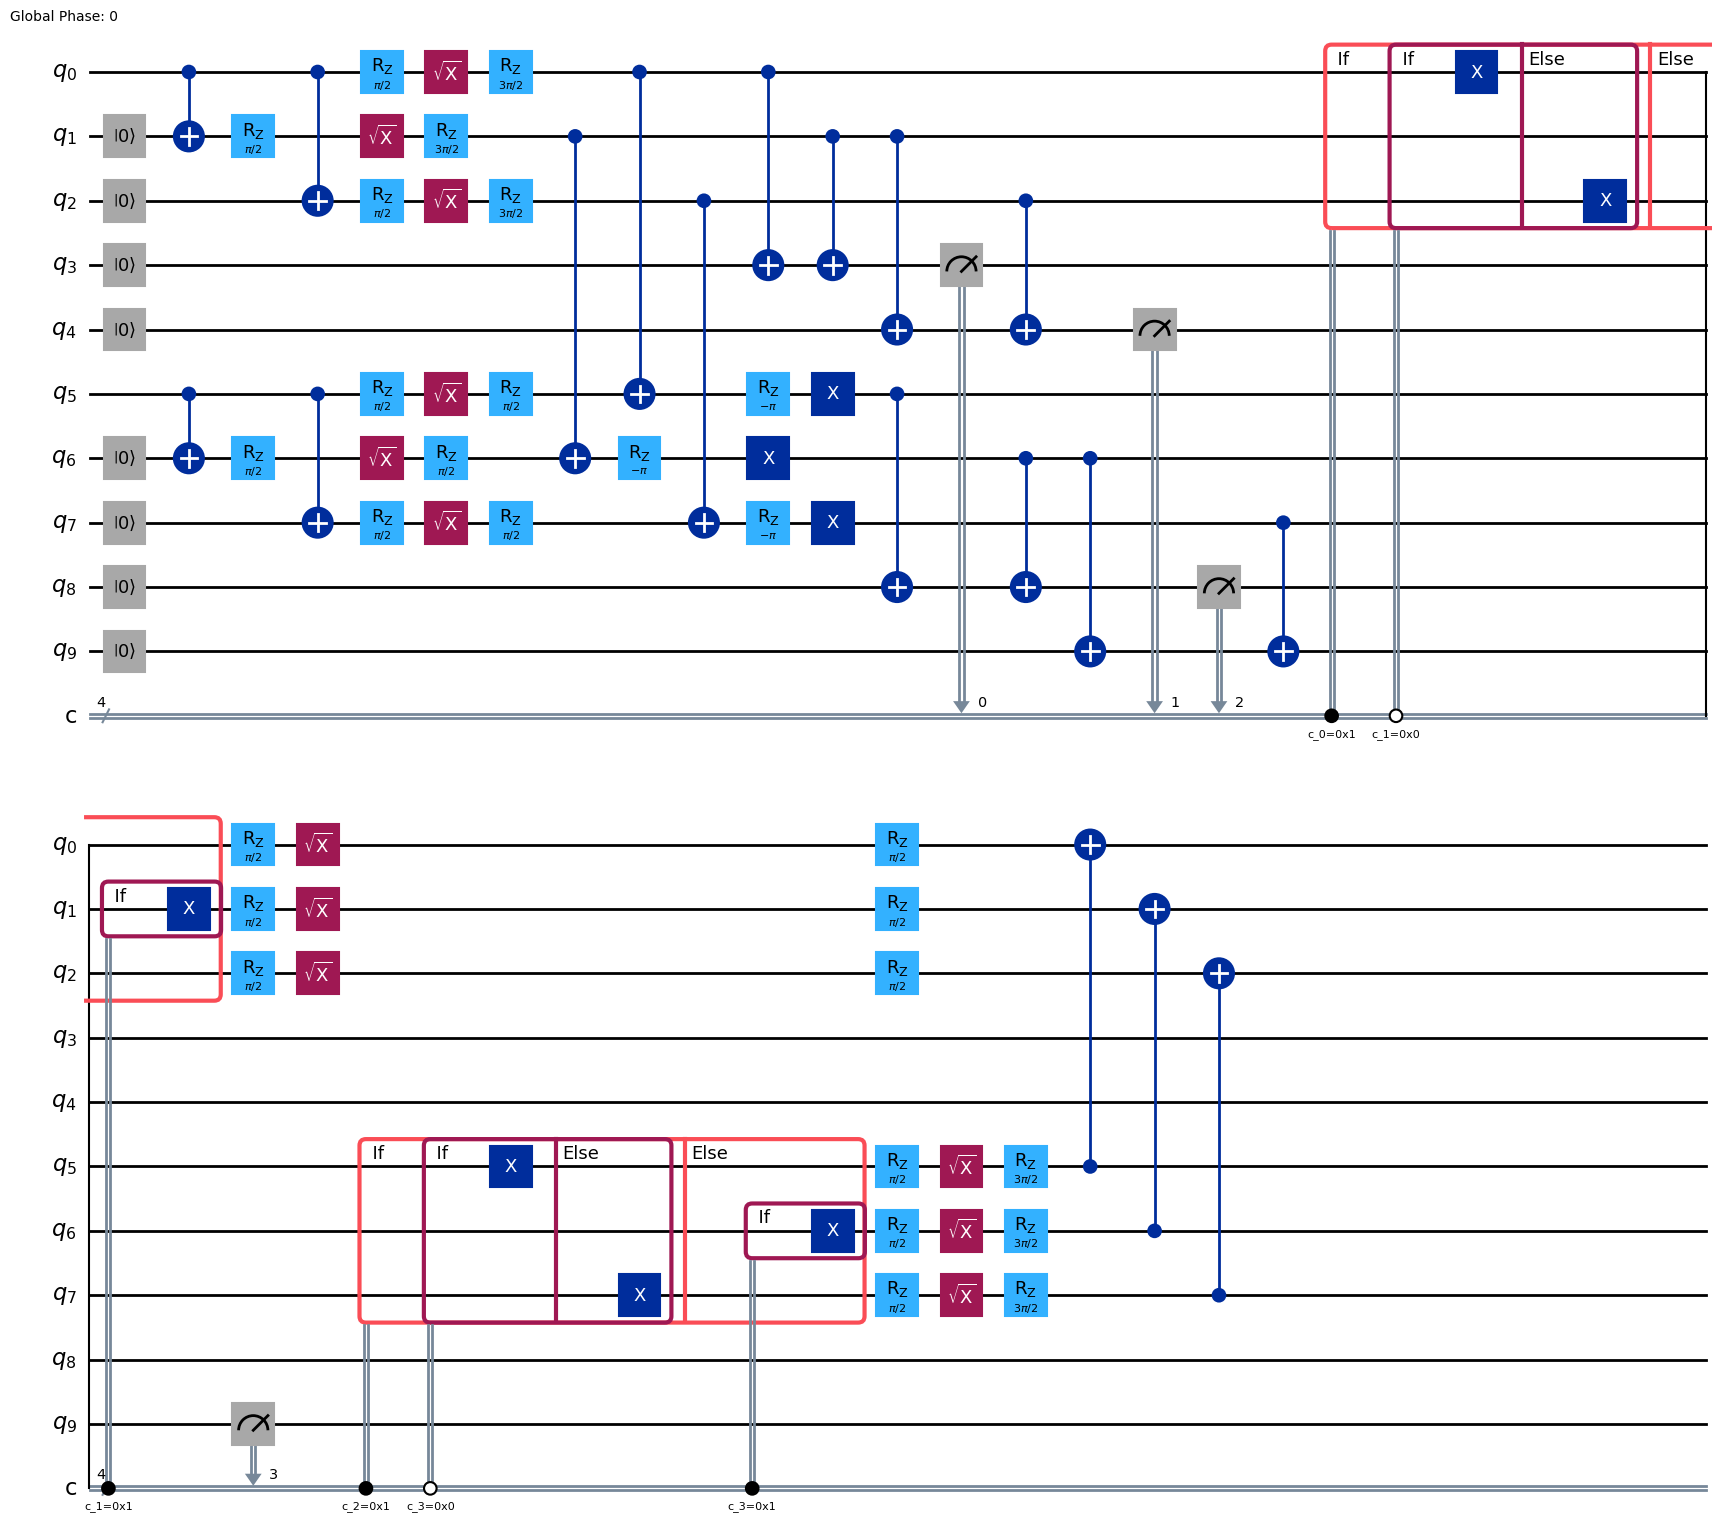

In [5]:
# Transpile the circuit
qc = qc.decompose()
qc = transpile(qc, basis_gates=['rz', 'sx', 'x', 'cx'], optimization_level=3)
# Draw the circuit
qc.draw('mpl')

In [9]:
# Gate count and depth
print("Gate count:", qc.count_ops())
print("Circuit depth:", qc.depth())

Gate count: OrderedDict({'rz': 27, 'cx': 18, 'sx': 12, 'reset': 8, 'x': 4, 'measure': 4, 'if_else': 2})
Circuit depth: 20


### One Switch Case Optimization:
- We may flatten a nested-if into switch case statements
- We assume one nest-case and try to optimize on that

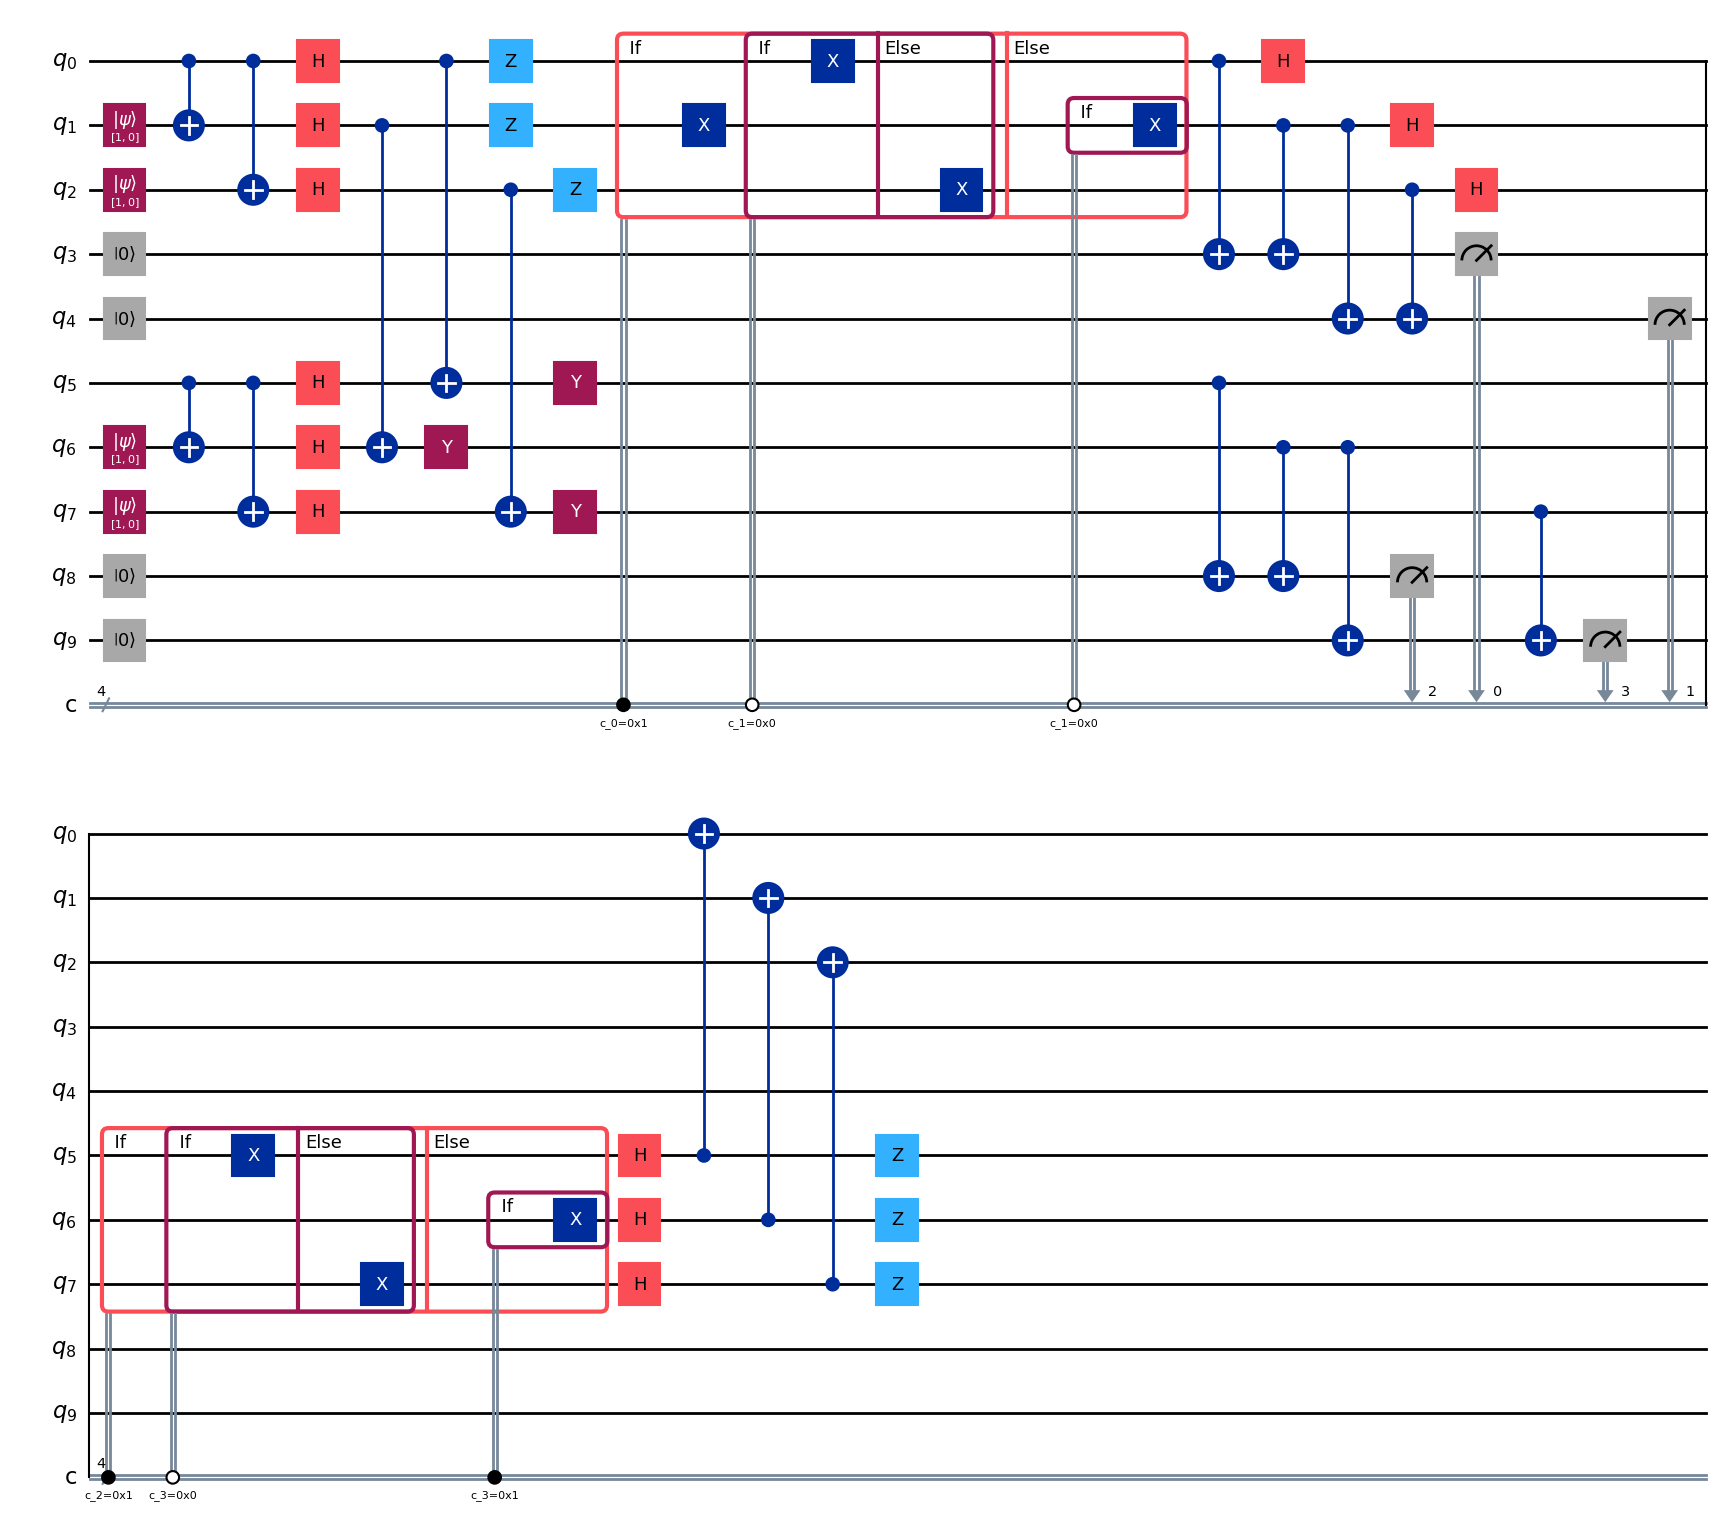

In [6]:
# Combine one switch case
qc_2 = QuantumCircuit(5*num_qubits, 2*num_qubits)

# Duplicate
for i in range(num_qubits):
    qc_2.initialize([1, 0], qc_2.qubits[5*i+1])
    qc_2.initialize([1, 0], qc_2.qubits[5*i+2])
    qc_2.cx(qc.qubits[5*i], qc_2.qubits[5*i+1])
    qc_2.cx(qc.qubits[5*i], qc_2.qubits[5*i+2])

# Do operations on physical qubits (before)
a = 0
b = 5
for i in range(3):
    qc_2.h(qc_2.qubits[a+i])
    qc_2.h(qc_2.qubits[b+i])
    qc_2.cx(qc_2.qubits[a+i], qc_2.qubits[b+i])
    qc_2.z(qc_2.qubits[a+i])
    qc_2.y(qc_2.qubits[b+i])

# ASSUMPTION
qc.x(qc_2.qubits[1])

# Compare
with qc_2.if_test((qc_2.clbits[0], 1)) as else__:
    qc_2.x(qc_2.qubits[1])
    with qc_2.if_test((qc_2.clbits[1], 0)) as else_:
        qc_2.x(qc_2.qubits[0])
    with else_:
        qc_2.x(qc_2.qubits[2])
with else__:
    with qc_2.if_test((qc_2.clbits[1], 0)) as else_:
        qc_2.x(qc_2.qubits[1])

# Error correct fir
qc_2.compose(qec_bit, [0, 1, 2, 3, 4], [0, 1], inplace=True)

qc_2.compose(qec_bit, [5, 6, 7, 8, 9], [2, 3], inplace=True)
error_correct(qc_2, [5, 6, 7, 8], [2, 3])

# Do operations on physical qubits (after)
for i in range(3):
    qc_2.h(qc_2.qubits[a+i])
    qc_2.h(qc_2.qubits[b+i])
    qc_2.cx(qc_2.qubits[b+i], qc_2.qubits[a+i])
    qc_2.z(qc_2.qubits[b+i])

# Draw the circuit
qc_2.draw('mpl')

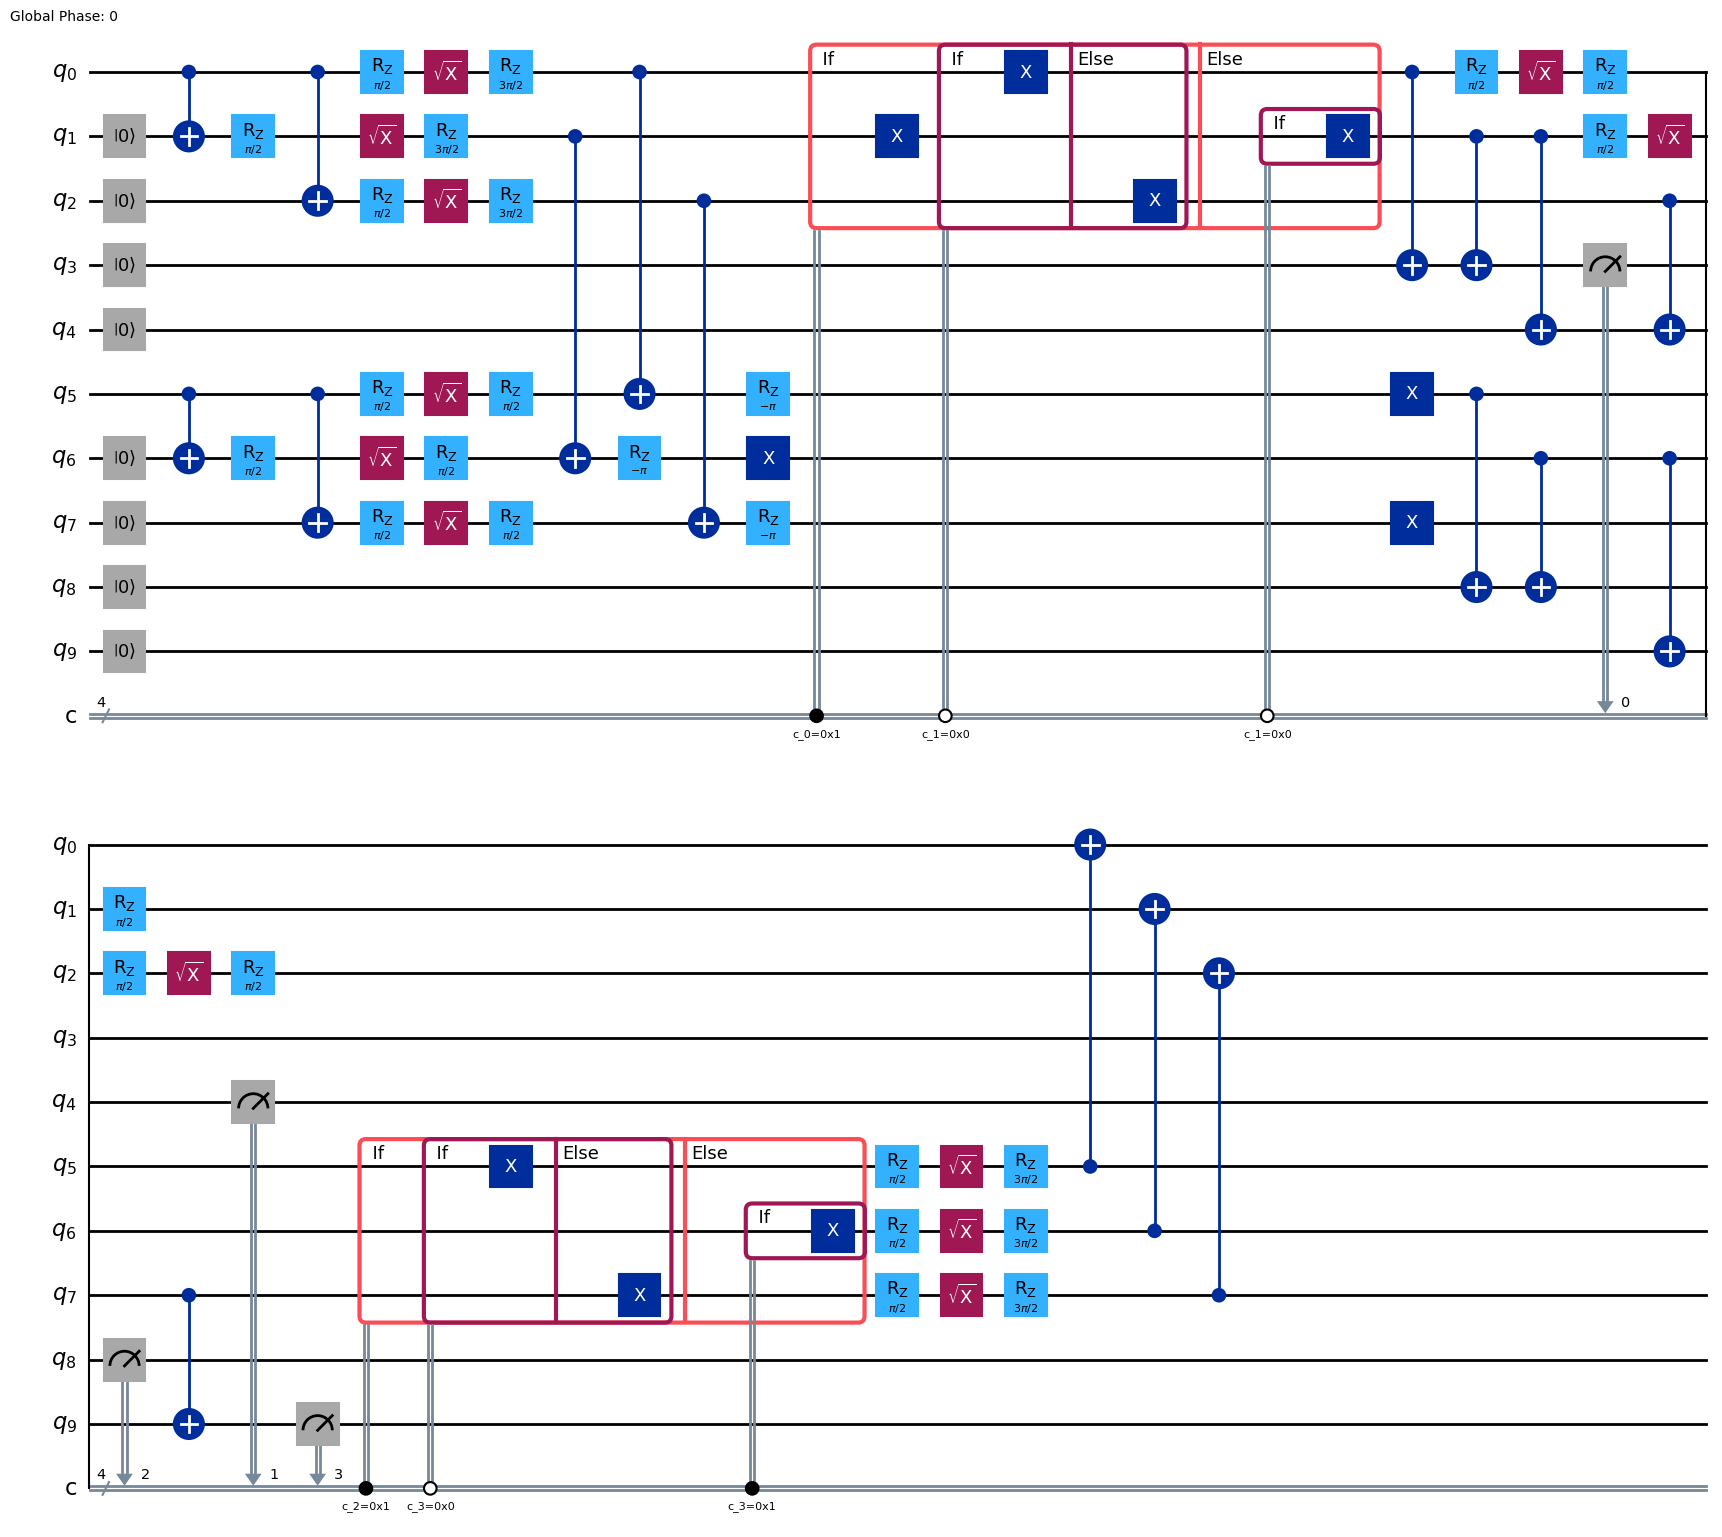

In [7]:
# Gate Count and depth for qc_2
qc_2 = qc_2.decompose()
qc_2 = transpile(qc_2, basis_gates=['rz', 'sx', 'x', 'cx'], optimization_level=3)
# Draw the circuit
qc_2.draw('mpl')

In [8]:
# Gate Count and depth
print("Gate count:", qc_2.count_ops())
print("Depth:", qc_2.depth())

Gate count: OrderedDict({'rz': 27, 'cx': 18, 'sx': 12, 'reset': 8, 'measure': 4, 'x': 3, 'if_else': 2})
Depth: 19
